In [1]:
import torch
from torchvision import models, transforms
import pickle

from PIL import Image
import matplotlib.pyplot as plt

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
import json

with open("imagenet_class_index.json", "r") as f:
    imagenet_id_to_name = {int(cls_id): name for cls_id, (label, name) in json.load(f).items()}

# let's preview the first few class names 
dict(sorted(imagenet_id_to_name.items())[: 10])

{0: 'tench',
 1: 'goldfish',
 2: 'great_white_shark',
 3: 'tiger_shark',
 4: 'hammerhead',
 5: 'electric_ray',
 6: 'stingray',
 7: 'cock',
 8: 'hen',
 9: 'ostrich'}

In [4]:
def load_image(image_path):
    return Image.open(image_path).convert("RGB")

def visualize_image(image):
    plt.figure(figsize=(10, 10))
    plt.imshow(image)

In [15]:
def custom_padding(image):
    width, height = image.size
    pad = int(abs(height - width) / 2)
    
    new_width = width + pad + pad
    new_height = height + pad + pad
    
    result = Image.new(image.mode, (new_width, new_height), (255,255,255))
    
    result.paste(image, (pad, pad))

    return result

add_pad = transforms.Lambda(lambda img: custom_padding(img))

def transform_image(image):
    transform = transforms.Compose([
        add_pad,
        transforms.Resize(
            518,
            interpolation=transforms.InterpolationMode.BICUBIC,
        ),
        transforms.CenterCrop(518),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]
        ),
    ])
    image = transform(image)
    # we also add a batch dimension to the image since that is what the model expects
    image = image[None, :]
    return image

In [16]:
def visualize_and_predict(model, image_path):
    image = load_image(image_path)
    visualize_image(image)
    image = transform_image(image)

    image = image.to(device)
    
    # we do not need to track gradients for inference
    with torch.no_grad():
        _, preds = model(image).topk(10)
    
    # convert preds to a Python list and remove the batch dimension
    preds = preds.tolist()[0]

    return [imagenet_id_to_name[cls_id] for cls_id in preds]

def predict(model, image_path):
    image = load_image(image_path)
    image = transform_image(image)

    image = image.to(device)
    
    # we do not need to track gradients for inference
    with torch.no_grad():
        _, preds = model(image).topk(10)
    
    # convert preds to a Python list and remove the batch dimension
    preds = preds.tolist()[0]

    return [imagenet_id_to_name[cls_id] for cls_id in preds]

In [17]:
pretrained_model = models.vit_h_14(weights='DEFAULT')

In [18]:
pretrained_model.to(device)

VisionTransformer(
  (conv_proj): Conv2d(3, 1280, kernel_size=(14, 14), stride=(14, 14))
  (encoder): Encoder(
    (dropout): Dropout(p=0.0, inplace=False)
    (layers): Sequential(
      (encoder_layer_0): EncoderBlock(
        (ln_1): LayerNorm((1280,), eps=1e-06, elementwise_affine=True)
        (self_attention): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=1280, out_features=1280, bias=True)
        )
        (dropout): Dropout(p=0.0, inplace=False)
        (ln_2): LayerNorm((1280,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (0): Linear(in_features=1280, out_features=5120, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.0, inplace=False)
          (3): Linear(in_features=5120, out_features=1280, bias=True)
          (4): Dropout(p=0.0, inplace=False)
        )
      )
      (encoder_layer_1): EncoderBlock(
        (ln_1): LayerNorm((1280,), eps=1e-06, elementwise_affine=True)
       

['espresso',
 'coffee_mug',
 'eggnog',
 'cup',
 'packet',
 'espresso_maker',
 'consomme',
 'street_sign',
 'bakery',
 'tobacco_shop']

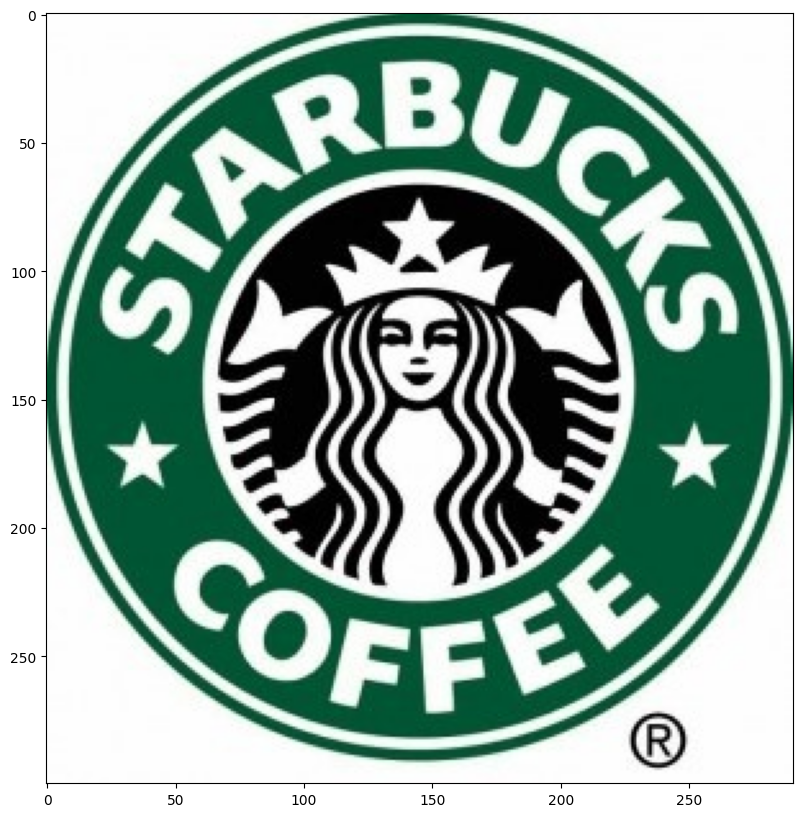

In [19]:
visualize_and_predict(pretrained_model, "./starbucks-logo-1992.jpg")

In [20]:
from tqdm import tqdm
import os

In [21]:
outputLabels = []

In [22]:
for image_path in tqdm(os.listdir("./small_images/")):
    labels = predict(pretrained_model, f"./small_images/{image_path}")
    outputLabels.append({"image": image_path, "label": labels})

 17%|█▋        | 517/3098 [01:27<07:16,  5.91it/s]


KeyboardInterrupt: 

In [ ]:
with open('imageNet.pkl', 'wb') as f:
    # A new file will be created
    pickle.dump(outputLabels, f)

In [23]:
labels = []
with (open("imageNet.pkl", "rb")) as openfile:
    labels = pickle.load(openfile)

In [24]:
labels[0]

{'image': '70021464.png',
 'label': ['digital_watch',
  'stopwatch',
  'analog_clock',
  'digital_clock',
  'television',
  'matchstick',
  'web_site',
  'wall_clock',
  'magnetic_compass',
  'buckle']}

['running_shoe',
 'soccer_ball',
 'sweatshirt',
 'jersey',
 'racket',
 'basketball',
 'tennis_ball',
 'envelope',
 'web_site',
 'stopwatch']

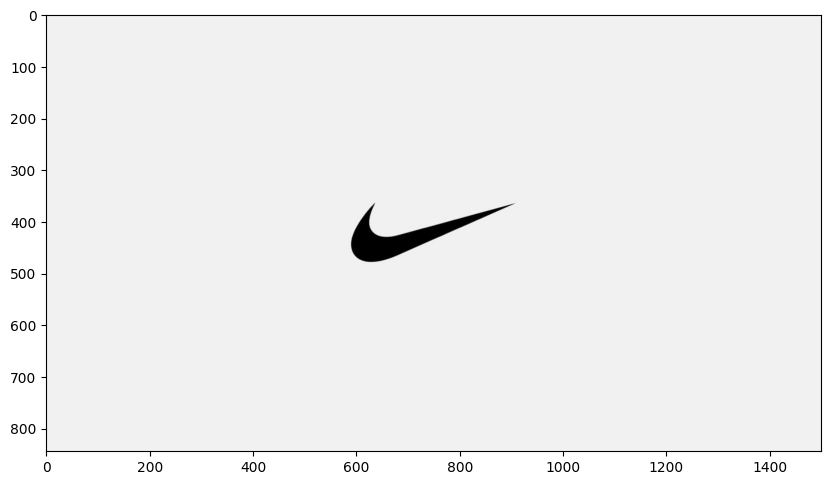

In [26]:
preds = visualize_and_predict(pretrained_model, "./test.jpg")
preds

In [27]:
topK = []

In [28]:
for label in tqdm(labels):
    currIterLabels = label["label"]

    numSimilar = 0

    for pred in preds:
        if pred in currIterLabels:
            numSimilar += 1
            
    label["numSimilar"] = numSimilar

100%|██████████| 3097/3097 [00:00<00:00, 602856.99it/s]


In [29]:
import pandas as pd

In [30]:
df = pd.DataFrame.from_dict(labels)

In [31]:
most_similar = df.sort_values(by=["numSimilar"], ascending = False).head(5)
most_similar

,image,label,numSimilar
3096,test.jpg,"[running_shoe, soccer_ball, sweatshirt, jersey...",10
2668,73302503.png,"[running_shoe, jersey, sweatshirt, shoe_shop, ...",7
2435,73142880.png,"[jersey, maillot, sweatshirt, cock, racket, so...",6
3095,PUMA_Logo.jpg,"[cougar, running_shoe, jersey, web_site, shoe_...",6
1697,72411907.png,"[jersey, tennis_ball, soccer_ball, maillot, sw...",6


In [32]:
import matplotlib.pyplot as plt

numCol = 6
numRow = 1

def setAxes(ax, image, query = False, **kwargs):
    value = kwargs.get("value", None)
    if query:
        ax.set_xlabel("Query Image\n{0}".format(image), fontsize = 12)
    else:
        ax.set_xlabel("Number of similar labels: {1}\n{0}".format( image,  value), fontsize = 12)
    ax.set_xticks([])
    ax.set_yticks([])

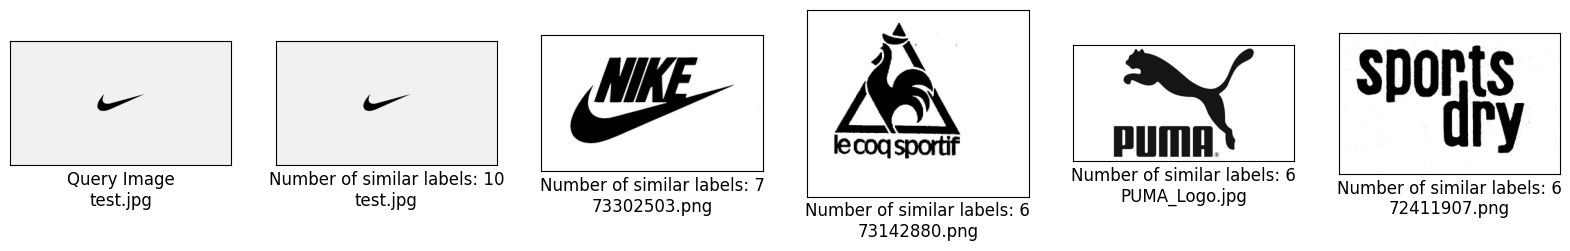

In [33]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(20, 30))

for j in range(6):
    ax = []
    if j == 0:
        img = Image.open(f"./test.jpg")
        ax = fig.add_subplot(numRow, numCol, 1)
        setAxes(ax, "test.jpg", most_similar.iloc[0].numSimilar)
    else:
        img = Image.open(os.path.join("./small_images/", most_similar.iloc[j-1].image))
        ax.append(fig.add_subplot(numRow, numCol, j+1))
        setAxes(ax[-1], most_similar.iloc[j-1].image, value = most_similar.iloc[j-1].numSimilar)

    img = img.convert('RGB')
    plt.imshow(img)
    img.close()

plt.show()